This is Part VI of the notebook with some experiments in using the Yamnet pre-trained neural network for classifying and evaluating bird audio recordings from the Cacophony project.

In this notebook very large scale testing is performed on a signifcant part of the full Cacophony Database
but <i> unlike </i> in part IV this is done <b> without </b> any filtering on the audio files. 


See [part I](Yamnet_Audio_Classification_Experiments_Part_1.ipynb) for a full background

Quentin McDonald <br>
October 2021

In [43]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.style.use('seaborn')
import datetime
from datetime import  timedelta
import pytz
from suntime import Sun, SunTimeException 
from IPython.core.display import display, HTML

In [44]:
# CHRISTCHURCH LAT/LONG
lat = 43.5320
long = 172.6306
sun = Sun(lat, long)

In [45]:
# Most analyses will only consider devices which reorced more
MIN_NUM_RECORDINGS = 1000

<H2> Processing and reading the data </H2>

The scoring is done with [this](score_db.py) Python script. For a given date range this script downloads each audio recording into a temporary memory buffer, scores it and adds the scores (along with the ID, some device info and the earlier Cacophony Index) into a record in the "scores.db" SQLite3 database.

In [46]:
con = sqlite3.connect("scores_nofilt.db", detect_types=sqlite3.PARSE_DECLTYPES | sqlite3.PARSE_COLNAMES)
scores_df = pd.read_sql_query("SELECT * from scores", con)
con.close()

In [47]:

# Convert dates to datetime objects
scores_df['ts'] = pd.to_datetime(scores_df['ts'], format='%Y-%m-%d %H:%M:%S', utc=True)
scores_df['ts'] = scores_df['ts'].dt.tz_convert('Pacific/Auckland')
# Remove the few records which have no or bad latitude or longtitude:
scores_df = scores_df[abs(scores_df['latitude']) > 30.0 ]
scores_df = scores_df[abs(scores_df['longtitude']) > 150 ]
# Clamp (missing) negative CI values to zero:
scores_df["ci_score"] = scores_df['ci_score'].clip(lower=0) 

In [48]:
 # compute the hours from sunrise:
def hours_from_sunrise(ts, lat,long):
    """
     Compute the hours from sunrise based on the timestamp and the lat/long position
        
        
    """
    day = ts.date()
    tm = ts.time()
    local_tz = pytz.timezone("Pacific/Auckland")
    local_datetime = datetime.datetime(day.year,day.month,day.day,tm.hour,tm.minute,tm.second).astimezone(local_tz)
    local_day = datetime.date(day.year,day.month,day.day)
    local_sun = Sun(lat, long)
    sr = local_sun.get_local_sunrise_time(local_datetime.astimezone(pytz.utc).date())
    # Move back to the day of the timestamp, won't be 100% accurate but not by much:
    sr = sr.replace(day=day.day,month=day.month,year=day.year)
    diff = (local_datetime-sr)/timedelta(hours=1)

    return diff
    
    
scores_df["hours_from_sunrise"] = [hours_from_sunrise(row[0],row[1],row[2]) for row in zip(scores_df['ts'],scores_df['latitude'],
                               scores_df['longtitude'])]

In [49]:
scores_df.describe()

,id,dev_id,thresh_score,class_score,ci_score,latitude,longtitude,hours_from_sunrise
count,456563.000000,456563.000000,456563.000000,456563.000000,456563.000000,456563.000000,456563.000000,456563.000000
mean,549583.528943,755.412202,0.044611,0.085139,0.435142,-40.092186,174.095157,5.337731
std,217324.745054,328.657899,0.134663,0.181231,0.202385,2.933269,1.032642,6.897057
min,167712.000000,378.000000,0.000000,0.000000,0.000000,-43.839088,170.233613,-8.066389
25%,355846.500000,485.000000,0.000000,0.000000,0.388500,-43.574850,172.970550,-0.666667
50%,537578.000000,640.000000,0.000000,0.004016,0.460000,-41.221350,174.573450,5.129722
75%,737043.500000,830.000000,0.012048,0.068273,0.561500,-36.816750,174.943350,11.522500
max,999061.000000,1650.000000,0.991968,0.991968,0.833000,-35.072550,176.341050,18.300278


In [50]:
scores_df.head()

,id,ts,dev_name,dev_id,thresh_score,class_score,ci_score,latitude,longtitude,hours_from_sunrise
0,167712,2018-08-22 14:07:34+12:00,RwwpRS5nk8Uncz3KfcD4,388,0.0,0.0,0.0295,-43.81155,172.97145,6.892778
1,167713,2018-08-22 15:07:34+12:00,RwwpRS5nk8Uncz3KfcD4,388,0.0,0.0,0.0000,-43.81155,172.97145,7.892778
2,167714,2018-08-22 16:10:24+12:00,RwwpRS5nk8Uncz3KfcD4,388,0.0,0.0,0.0000,-43.81155,172.97145,8.940000
3,167715,2018-08-22 17:12:26+12:00,RwwpRS5nk8Uncz3KfcD4,388,0.0,0.0,0.0215,-43.81155,172.97145,9.973889
4,167716,2018-08-22 17:22:30+12:00,RwwpRS5nk8Uncz3KfcD4,388,0.0,0.0,0.0000,-43.81155,172.97145,10.141667


<H2> Score by day over the entire dataset </H2>


In [51]:
def plot_scores_by_day(df, method='mean', title="", normalize_by_daylight_hours = False,
                      show_class=True, show_thresh=True, show_ci = True, show_daylight_hours = True,
                      ewm_span = 15):
    """
    For the score data in df, plot the mean, median or max (depends on "method") score per day for 
    any of the three scores available
    
    
    """
    
    def calc_daylight_hours(day):
        """
        Calculate the number of daylight hours on the given day:
        """
        local_day = datetime.date(day.year,day.month,day.day)
        sr = sun.get_local_sunrise_time(local_day)
        ss = sun.get_local_sunset_time(local_day)
        return (sr-ss)/datetime.timedelta(hours=1)
    
    
    if method == 'mean':
        scores_by_day_df = df.groupby(by=df['ts'].dt.date).mean()
    elif method=='median':
        scores_by_day_df = df.groupby(by=df['ts'].dt.date).median()
    elif method=='max':
        scores_by_day_df = df.groupby(by=df['ts'].dt.date).max()
    else:
        raise ValueError("Invalid method " + method)
    
    
    
    scores_by_day_df['daylight_hours'] = scores_by_day_df.index.map(calc_daylight_hours)
    
    
    if( normalize_by_daylight_hours ):
        scores_by_day_df['class_score'] = scores_by_day_df['class_score']/scores_by_day_df['daylight_hours'] 
        scores_by_day_df['thresh_score'] = scores_by_day_df['thresh_score']/scores_by_day_df['daylight_hours'] 
        scores_by_day_df['ci_score'] = scores_by_day_df['ci_score']/scores_by_day_df['daylight_hours'] 
        
      
    scores_by_day_df['class_score_ema'] = scores_by_day_df['class_score'].ewm(span=ewm_span,adjust=False).mean()
    scores_by_day_df['thresh_score_ema'] = scores_by_day_df['thresh_score'].ewm(span=ewm_span,adjust=False).mean()
    scores_by_day_df['ci_score_ema'] = scores_by_day_df['ci_score'].ewm(span=ewm_span,adjust=False).mean()
    
    
    fig = plt.figure(2,figsize=(12,10))
    ax = fig.subplots(1)
    ax.set_xlabel("Date")
    ax.set_ylabel("Score")
    
    lns = []
    
    if show_class:
        l = ax.plot(scores_by_day_df['class_score'], c="#222299", linewidth=1,label="Class Score")
        ax.plot(scores_by_day_df['class_score_ema'], linewidth=3,linestyle='dotted',c="#222299")
        lns = lns + l
    
    if show_thresh:
        l = ax.plot(scores_by_day_df['thresh_score'], c="#DD8822", linewidth=1,label="Threshold Score")
        ax.plot(scores_by_day_df['thresh_score_ema'], linewidth=3,linestyle='dotted',c="#DD8822")
        lns = lns + l
    
    if show_ci:
        l = ax.plot(scores_by_day_df['ci_score'], c="#228822",linewidth=1, label="CI Score")
        ax.plot(scores_by_day_df['ci_score_ema'], linewidth=3,linestyle='dotted',c="#228822")
        lns = lns + l
        
    
    ax.set_title(title );
   
    if show_daylight_hours:
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        l = ax2.plot(scores_by_day_df['daylight_hours'],c='#AA2255',linewidth=2,linestyle='dashed',
                    label='Daylight Hours')
        ax2.set_ylabel("Daylight Hours")
        lns = lns + l
        
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%h-%y'))
    
    
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    
    
    plt.show()

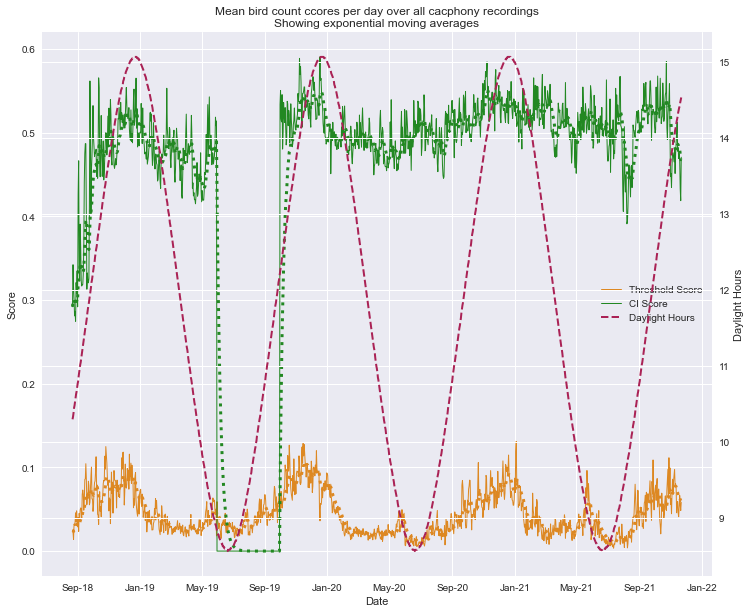

In [52]:
plot_scores_by_day(scores_df,method="mean", 
                   title = "Mean bird count ccores per day over all cacphony recordings\nShowing exponential moving averages",
                   show_class=False)

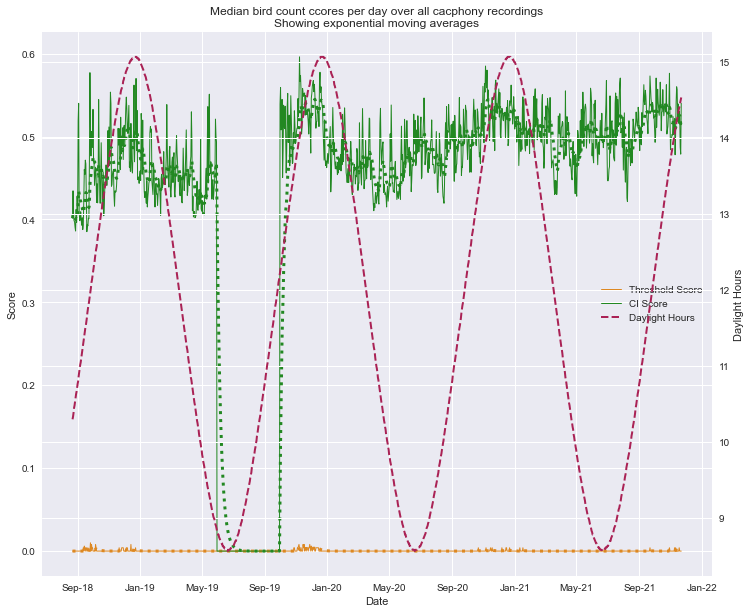

In [53]:
plot_scores_by_day(scores_df,method="median",
                    title = "Median bird count ccores per day over all cacphony recordings\nShowing exponential moving averages",
                   show_class=False)

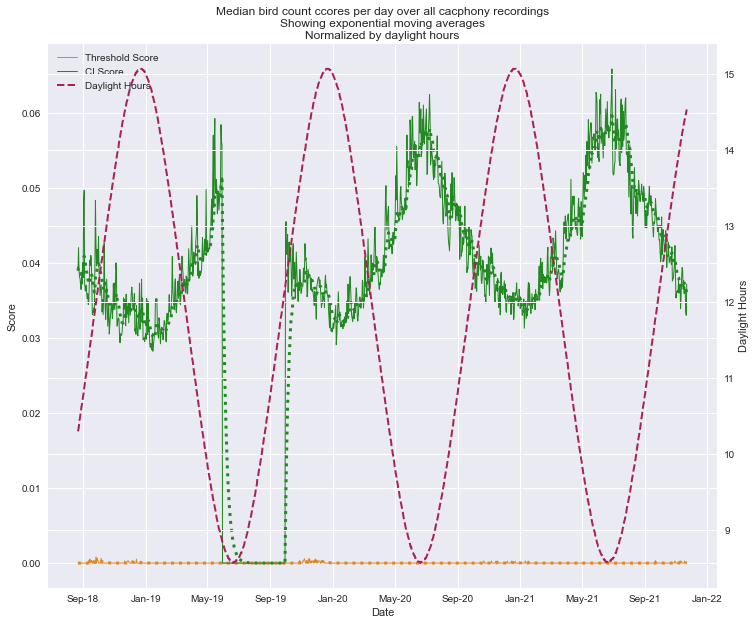

In [54]:
plot_scores_by_day(scores_df, method="median",
                   title = "Median bird count ccores per day over all cacphony recordings\nShowing exponential moving averages\nNormalized by daylight hours",
                   normalize_by_daylight_hours=True, show_class=False)

In [55]:
def plot_counts_by_day(df):
    """
    For the score data in df, plot the number of recordings per day
    
    """
    counts_by_day_df = df.groupby(by=df['ts'].dt.date).count()
    counts_by_day_df['id_ema'] = counts_by_day_df['id'].ewm(span=15,adjust=False).mean()
   
    fig = plt.figure(2,figsize=(12,10))
    ax = fig.subplots(1)
    
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Recordings")
    ax.plot(counts_by_day_df['id'], c="#222299", linewidth=1)
    ax.plot(counts_by_day_df['id_ema'], linewidth=2,linestyle='dotted',c="#222299")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%h-%y'))
    
    ax.set_title("Number of recordings per day over all Cacphony recordings\nShowing exponential moving averages")
   
    plt.show()

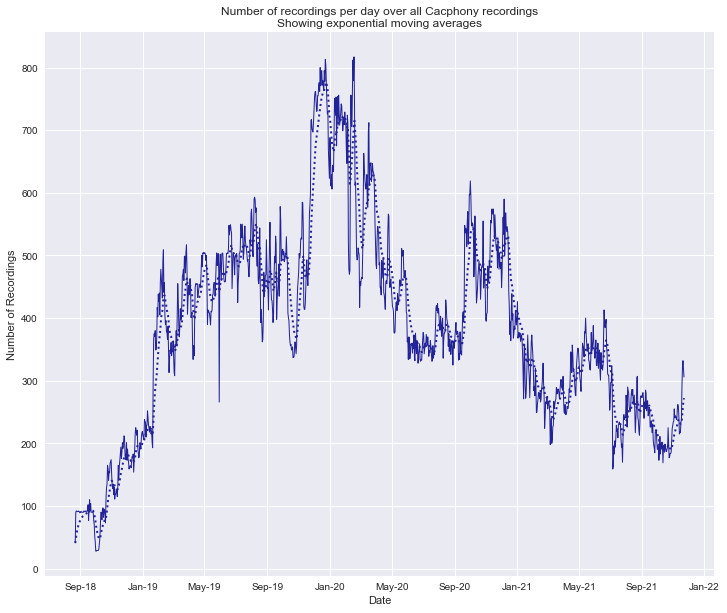

In [56]:
plot_counts_by_day(scores_df)

<H3> Device continuity over time </H3>

In [57]:
def plot_device_recordings(df, min_num_recordings=1000):
    """
    Create a matrix of those devices with at least 'min_num_recordings'showing which days they uploaded
    a recording

    """
    def assign_recordings_to_mat(ts,dev_name, mat, start_date, dev_to_idx):
        day = ts.date()
        day_idx = int((day-start_date)/datetime.timedelta(days=1))
        if dev_name in dev_to_idx:
            dev_idx=dev_to_idx[dev_name]
            mat[day_idx,dev_idx] = dev_idx + 1
        
        
    # Create a dataframe grouped by day - index will be days
    counts_by_day_df = df.groupby(by=df['ts'].dt.date).count()
    days = np.array(counts_by_day_df.index)
    days_len = int((days[-1] - days[0])/datetime.timedelta(days=1)) +1
    counts_by_dev_df = df.groupby(by=df['dev_name']).count()
    counts_by_dev_df = counts_by_dev_df[counts_by_dev_df['id'] > min_num_recordings]
    counts_by_dev_df = counts_by_dev_df.sort_values(by='id', ascending = False )
    devs = np.array(counts_by_dev_df.index)
    
    # Create the matrix:
    mat = np.zeros((days_len,len(devs)), dtype=np.int8)
    
    dev_to_idx = {}
    dev_to_idx = { devs[i] : i for i in range(len(devs))}
    
    earliest_date = days[0]
    
    # Iterate over the recordings and assign each one of them to the matrix of recordings:
    result=[assign_recordings_to_mat(x,y, mat,earliest_date, dev_to_idx) for x,y in zip(df['ts'],df['dev_name']) ]
    
    fig = plt.figure(2,figsize=(12,10))
    ax = fig.subplots(1)
    ax.set_yticks([x for x in range(len(devs))])
    ax.set_yticklabels(devs)
    # mask some 'bad' data, in your case you would have: data == 0
    mat = np.ma.masked_where(mat < 0.05, mat)

    
    cmap = plt.cm.get_cmap("tab20b").copy()

    cmap.set_bad(color='black')
    xlims = [days[0],days[-1]]
    xlims =  mdates.date2num(xlims)
    ax.imshow(mat.T, aspect='auto', interpolation='none', cmap=cmap, extent=[xlims[0],xlims[1],len(devs),0])
    ax.grid(False, axis="y")
    ax.grid(True,axis="x", linewidth=0.5,c="#DDDDDD")
    ax.set_title("Device recordings per day")
    ax.set_ylabel("Device Name")
    ax.set_xlabel("Date")
    ax.xaxis_date()
    date_format = mdates.DateFormatter('%h-%y')
    ax.yaxis.set(ticks=np.arange(0.5, len(devs)), ticklabels=devs)
    ax.xaxis.set_major_formatter(date_format)

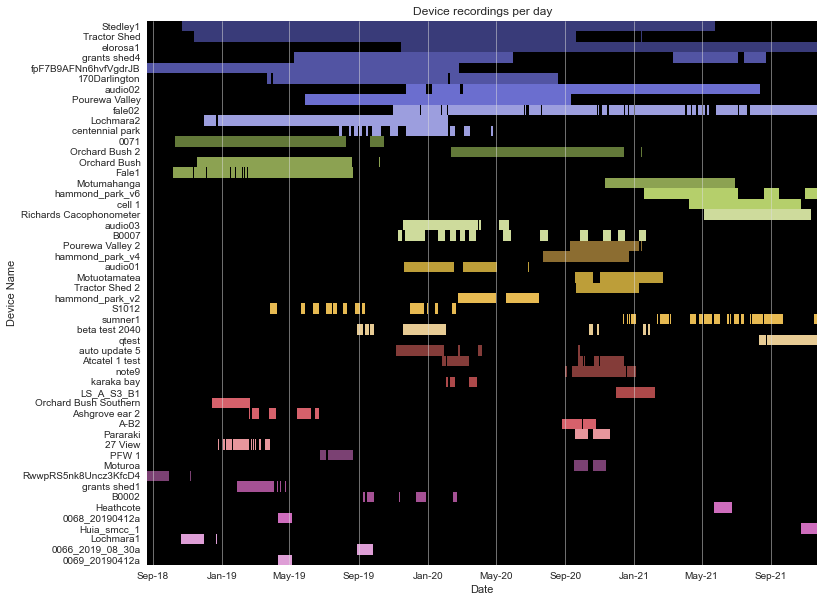

In [58]:
plot_device_recordings(scores_df, min_num_recordings = MIN_NUM_RECORDINGS)


<H2> Mean score around sunrise </H2>
Examine the trends in the scores either side of sunrise

In [59]:
def plot_dawn_score_distribution(df, max_hours_from_sunrise = 3,fraction=0.5, show_class = True, show_thresh = True, 
                                show_ci = True, title=""):
    """
    Plot the distribution of scores in df as a function of hours from sunrise in the range +/- "max_hours_from_sunrise"
    Which scores are plotted are controlled by "show_class", "show_thresh" and "show_ci"
    Plot only a random "fraction" of the dataset
    """
    
    plot_df = df[abs(df["hours_from_sunrise"]) < max_hours_from_sunrise].sample(frac=fraction)
    fig = plt.figure(2,figsize=(12,10))
    ax = fig.subplots(1)
    
    if show_thresh:
        ax.scatter(plot_df["hours_from_sunrise"], plot_df["thresh_score"], marker = ".", c="#DD8822", 
                   label="Threshold Score", s=10)
    if show_class:
        ax.scatter(plot_df["hours_from_sunrise"], plot_df["class_score"], marker = ".", c="#222299", 
                   label="Class Score", s=10)
    if show_ci:
        ax.scatter(plot_df["hours_from_sunrise"], plot_df["ci_score"], marker = ".", c="#228822", 
                   label="CI Score", s=10)
    ax.set_ylabel("Score")
    ax.set_xlabel("Hours from Sunrise")
    ax.set_title(title)
    ax.legend()
    plt.show()
    

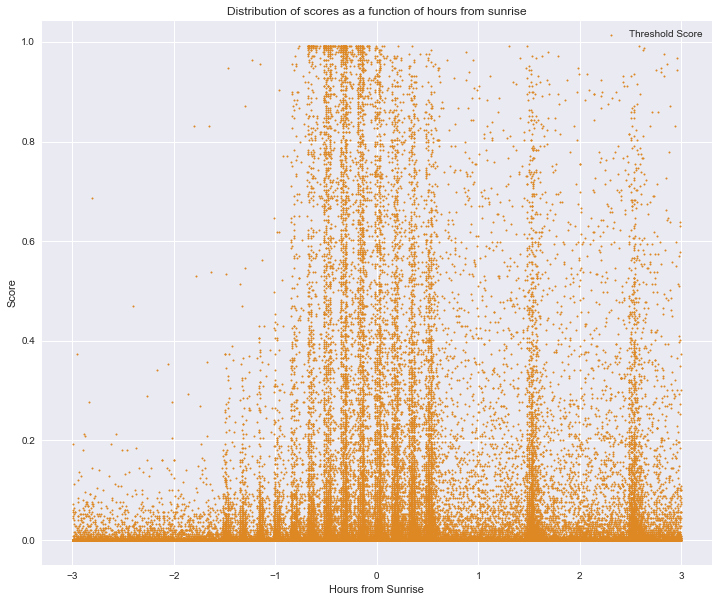

In [60]:
plot_dawn_score_distribution(scores_df, max_hours_from_sunrise=3, show_ci=False, show_class=False,
                            title = "Distribution of scores as a function of hours from sunrise")

In [61]:
def print_night_outliers(df, to_hour = -2, from_hour = -5, thresh_limit = 0.5):
    """
    Print links to the largest outliers in the hours before sunrise
    
    """
    outlier_df = df[(df['hours_from_sunrise'] > from_hour) & (df['hours_from_sunrise'] < to_hour)]
    outlier_df = outlier_df[outlier_df["thresh_score"] > thresh_limit]
    outlier_df = outlier_df.sort_values(by="thresh_score", ascending=False)
    outlier_df["link"] = ['<a target= "_blank" href="https://browse.cacophony.org.nz/recording/{}">{}</a>'.format(rid,rid) for rid in outlier_df["id"]]
    print("There are {} outliers".format(len(outlier_df)))
    display(HTML(outlier_df[["ts","dev_name","thresh_score","class_score","ci_score","link"]].to_html(escape=False)))
    
    

In [62]:

print_night_outliers(scores_df)


There are 3 outliers


,ts,dev_name,thresh_score,class_score,ci_score,link
90438,2019-06-13 04:41:38+12:00,Orchard Bush,0.686747,0.746988,0.0000,319750
485146,2021-10-31 01:39:37+13:00,Huia_smcc_1,0.642570,0.738956,0.6010,977471
44256,2019-03-12 03:14:01+13:00,fpF7B9AFNn6hvfVgdrJB,0.538153,0.566265,0.5835,262141


In [63]:
# Top threshold scores


def print_top_scores(df, to_print=20):
    """
    Print links to the top scorers
    
    """
    top_df = df.sort_values(by="thresh_score", ascending=False)
    top_df["link"] = ['<a target= "_blank" href="https://browse.cacophony.org.nz/recording/{}">{}</a>'.format(rid,rid) for rid in top_df["id"]]
    top_df = top_df.head(to_print)
  
    display(HTML(top_df[["ts","dev_name","thresh_score","class_score","ci_score","link"]].to_html(escape=False)))
    

In [64]:
print_top_scores(scores_df)

,ts,dev_name,thresh_score,class_score,ci_score,link
208047,2019-12-27 05:06:00+13:00,grants shed4,0.991968,0.991968,0.6985,471112
198621,2019-12-16 05:18:02+13:00,auto update 5,0.991968,0.991968,0.6825,458263
173427,2019-11-12 05:48:00+13:00,grants shed4,0.991968,0.991968,0.6470,423716
186403,2019-12-02 05:04:00+13:00,grants shed4,0.991968,0.991968,0.6935,441263
185607,2019-12-01 05:23:00+13:00,grants shed4,0.991968,0.991968,0.6960,440398
186404,2019-12-02 05:12:00+13:00,grants shed4,0.991968,0.991968,0.6895,441264
12678,2018-12-11 05:33:00+13:00,Stedley1,0.991968,0.991968,0.7085,208919
363848,2020-11-07 05:58:37+13:00,Motuotamatea,0.991968,0.991968,0.6720,715790
185606,2019-12-01 05:13:00+13:00,grants shed4,0.991968,0.991968,0.7055,440397
487859,2021-11-11 06:03:20+13:00,fale02,0.991968,0.991968,0.6630,987681


In [65]:
# Outliers in terms of largest differences between CI and Threshold scores:

def print_largest_diff_from_ci(df, num_to_print=20):
    """
    Print out a list of those records with the largest difference between thresh score and CI score
    """
    top_df = df[df["ci_score"] > 0.3 ]
    top_df = top_df[top_df["thresh_score"] > 0.3]
    top_df["score_ci_diff"] = [abs(t-c) for t,c in zip(top_df["thresh_score"],top_df["ci_score"])]
    top_df = top_df.sort_values(by="score_ci_diff", ascending=False)
    top_df["link"] = ['<a target= "_blank" href="https://browse.cacophony.org.nz/recording/{}">{}</a>'.format(rid,rid) for rid in top_df["id"]]
    top_df = top_df.head(num_to_print)
  
    display(HTML(top_df[["ts","dev_name","thresh_score","class_score","ci_score","link"]].to_html(escape=False)))
    

In [66]:

print_largest_diff_from_ci(scores_df)

,ts,dev_name,thresh_score,class_score,ci_score,link
352763,2020-10-09 07:41:05+13:00,A-B2,0.305221,0.477912,0.8060,697776
378650,2020-12-13 20:16:29+13:00,elorosa1,0.309237,0.453815,0.8070,744145
63850,2019-02-26 08:36:00+13:00,grants shed1,0.341365,0.646586,0.8325,285552
359938,2020-10-27 17:40:34+13:00,note9,0.313253,0.654618,0.8005,710118
374208,2020-12-01 11:22:00+13:00,kokako8,0.301205,0.473896,0.7790,736443
221703,2020-01-14 05:30:01+13:00,audio01,0.317269,0.425703,0.7855,488282
348496,2020-09-28 19:48:43+13:00,Atcatel 1 test,0.313253,0.465863,0.7810,689916
349105,2020-09-29 10:05:35+13:00,Atcatel 1 test,0.313253,0.654618,0.7745,690830
436852,2021-05-05 08:55:21+12:00,grants shed4,0.349398,0.530120,0.8040,843683
196287,2019-12-12 14:20:42+13:00,B0007,0.325301,0.506024,0.7785,455626


<H3> Box plot analysis by time from sunrise </H3>

In [67]:
def box_plot_from_sunrise(df, score, limit=3.5, step=0.5, title=""):
    """
    Show a box plot for values of "score" from -limit to +limit of sunrise in "step" increments
    
    """
    
    scores = []
    labels = []
    num_bins = int((limit*2)/step) -1
    
    for i in range(num_bins):
        left = -limit + i*step
        right = left + 2*step
        mid = left + step
        box_df = df[(df["hours_from_sunrise"] > left) & (df["hours_from_sunrise"] < right)]
        
        labels.append(mid)
        scores.append(np.array(box_df[score]))
    
    fig, ax1 = plt.subplots(figsize=(12,8))
    
    ax1.boxplot(scores, notch=False)
    ax1.set_xlabel("Hours from Sunrise")
    ax1.set_xticklabels(labels)
    ax1.set_ylabel("Score")
    ax1.set_title(title)
    plt.show()
    
    

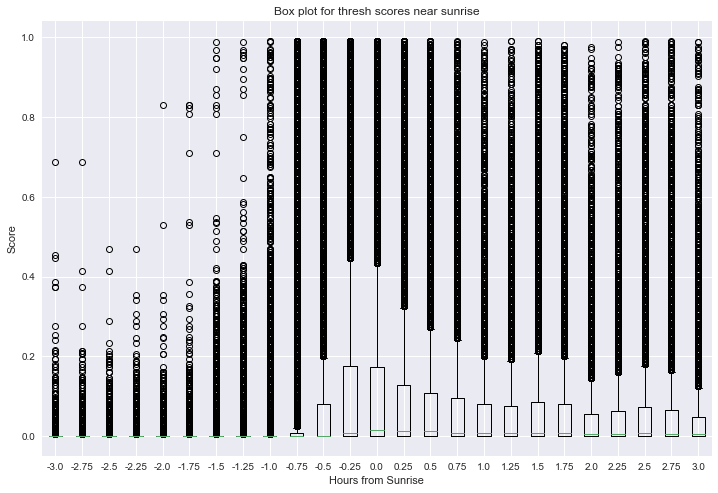

In [68]:
box_plot_from_sunrise(scores_df, "thresh_score", limit=3.25, step=0.25,
                      title="Box plot for thresh scores near sunrise")

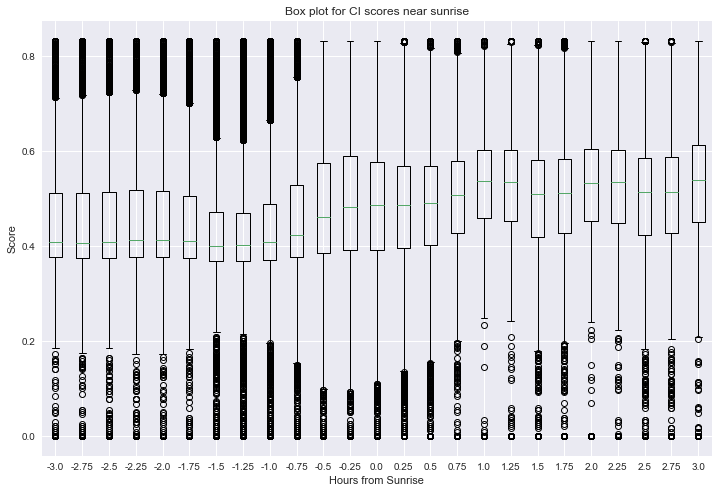

In [69]:
box_plot_from_sunrise(scores_df, "ci_score", limit=3.25, step=0.25,
                      title="Box plot for CI scores near sunrise")

Define dawn as +/- 1 hour of sunrise and examine the daily trends:

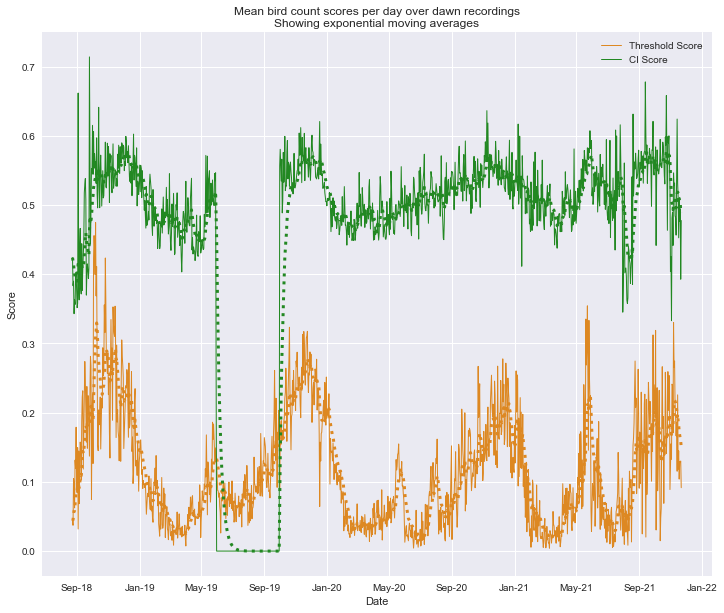

In [70]:
dawn_scores_df = scores_df[abs(scores_df["hours_from_sunrise"]) < 1.0]
plot_scores_by_day(dawn_scores_df, method="mean",
                title = "Mean bird count scores per day over dawn recordings\nShowing exponential moving averages",
                   normalize_by_daylight_hours=False,show_daylight_hours=False,
                   show_class=False)


<H2> Box Plot Analysis </H2>

In [71]:
def box_plot_by_month( df, score, title=""):
    """
    Create a box plot from the data in dataframe "df" for the "score" which is a column in "df"
    """
    
    g = df.groupby(pd.Grouper(key='ts', freq='M'))
    # groups to a list of dataframes with list comprehension
    dfs = [group for _,group in g]
    labels = [mth.strftime("%h-%y") for mth,_ in g]
    
    scores = []
    
    for d in dfs:
        scores.append(np.array(d[score]))
    
    fig, ax1 = plt.subplots(figsize=(10,6))
    
    ax1.boxplot(scores, notch=False)
    ax1.set_xlabel("Months")
    ax1.set_xticklabels(labels)
    ax1.set_ylabel("Score")
    ax1.set_title(title)
    plt.xticks(rotation = 45)
    plt.show()
    
    
    

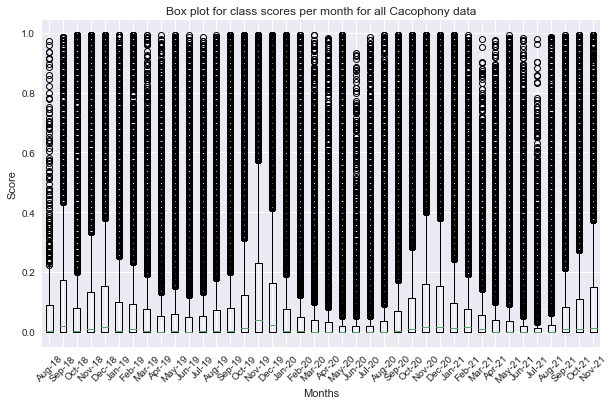

In [72]:
box_plot_by_month(scores_df, "class_score", "Box plot for class scores per month for all Cacophony data")

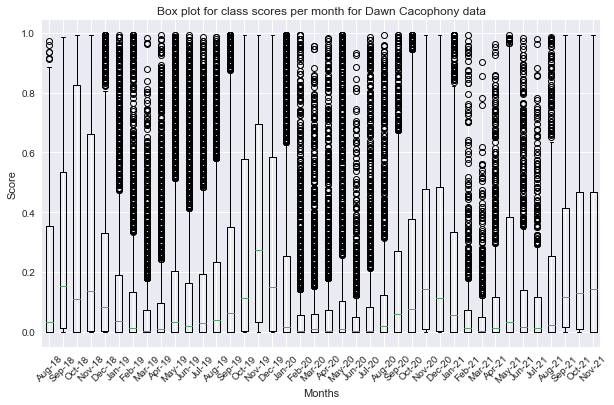

In [73]:
box_plot_by_month(dawn_scores_df, "class_score", "Box plot for class scores per month for Dawn Cacophony data")

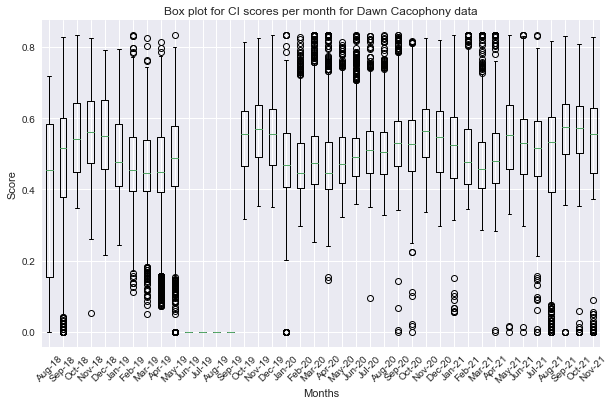

In [74]:
box_plot_by_month(dawn_scores_df, "ci_score", "Box plot for CI scores per month for Dawn Cacophony data")

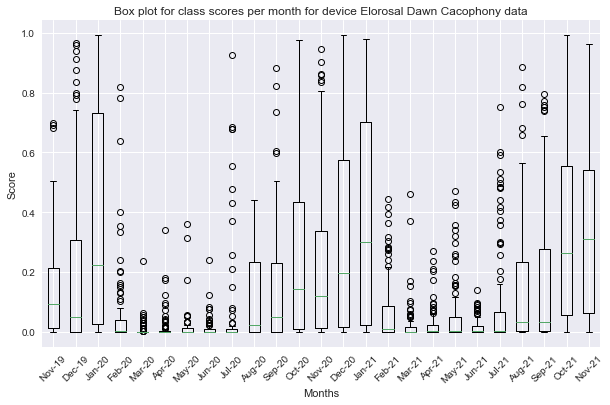

In [75]:
elorosa1_dawn_df = dawn_scores_df[dawn_scores_df.dev_name == "elorosa1"]
box_plot_by_month(elorosa1_dawn_df, "class_score", "Box plot for class scores per month for device Elorosal Dawn Cacophony data")

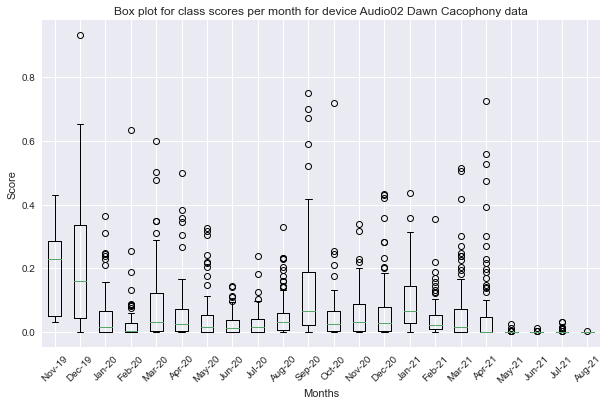

In [76]:
audio02_dawn_df = dawn_scores_df[dawn_scores_df.dev_name == "audio02"]
box_plot_by_month(audio02_dawn_df, "class_score", "Box plot for class scores per month for device Audio02 Dawn Cacophony data")

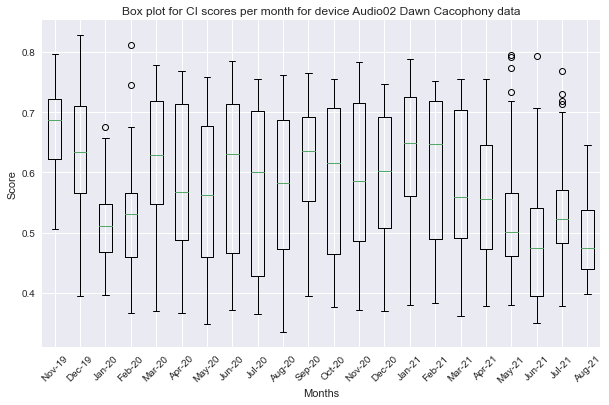

In [77]:
box_plot_by_month(audio02_dawn_df, "ci_score", "Box plot for CI scores per month for device Audio02 Dawn Cacophony data")

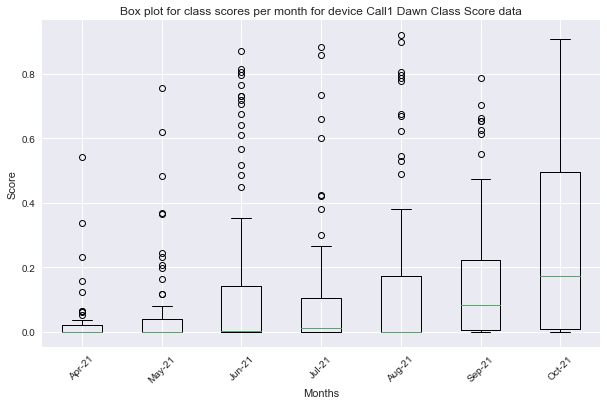

In [79]:
cell1_dawn_df = dawn_scores_df[dawn_scores_df.dev_name == "cell 1"]
box_plot_by_month(cell1_dawn_df, "class_score", "Box plot for class scores per month for device Call1 Dawn Class Score data")